Now we'll proceed to further feature engineering to improve the accuracy. 
Our current MAE is 17558.78 using Random Forests while ignoring columns with missing values.


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/train.csv')
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['object']).columns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
X.tail()  

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal


<Figure size 1000x600 with 0 Axes>

3 columns with missing values detected.
Filled missing values in column 'LotFrontage' with median value 69.0.
Filled missing values in column 'MasVnrArea' with median value 0.0.
Filled missing values in column 'GarageYrBlt' with median value 1980.0.


Text(0.5, 1.0, 'Top 20 Mutual Information Scores')

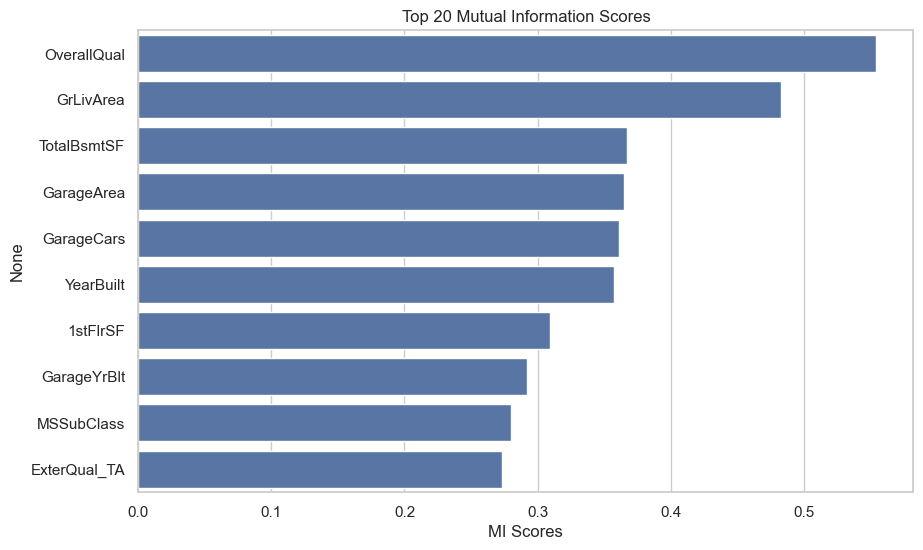

In [26]:
# Encode the categorical features using one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# get columns with missing values
missing_cols = X_encoded.columns[X_encoded.isnull().any()]
print(len(missing_cols), "columns with missing values detected.")

# fill missing values with median
for col in missing_cols:
    median_value = X_encoded[col].median()
    X_encoded = X_encoded.fillna(X_encoded.median(numeric_only=True))
    print(f"Filled missing values in column '{col}' with median value {median_value}.")


# calculate MI scores
from sklearn.feature_selection import mutual_info_regression

def get_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = get_mi_scores(X_encoded, y)

# plot MI scores
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores[:10], y=mi_scores.index[:10])
plt.title("Top 20 Mutual Information Scores")


In [45]:
# Select top k features based on MI scores
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(mutual_info_regression, k=200)
X_selected = selector.fit_transform(X_encoded, y)
selected_features = X_encoded.columns[selector.get_support()]
print("Selected features based on MI scores:", selected_features.tolist())

Selected features based on MI scores: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Alley_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighb

In [46]:
# Try Random Forest Regressor with cross-validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(n_estimators=200, random_state=42)
cv_scores = cross_val_score(model, X_encoded[selected_features], y, cv=5, scoring='neg_mean_absolute_error')
cv_mae_scores = -cv_scores
print("Cross-validated MAE scores:", cv_mae_scores)
print("Average CV MAE:", cv_mae_scores.mean())

KeyboardInterrupt: 

Since many features scored with an MI Score higher than .05, many features remain useful, so we'll try using XGboost or Gradient Descent.

In [47]:
# Try xgboost regressor
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X_encoded[selected_features], y, cv=5, scoring='neg_mean_absolute_error')
xgb_cv_mae_scores = -xgb_cv_scores  
print("XGBoost Cross-validated MAE scores:", xgb_cv_mae_scores)
print("XGBoost Average CV MAE:", xgb_cv_mae_scores.mean())

XGBoost Cross-validated MAE scores: [16184.12011719 17429.92773438 16785.68554688 14507.39257812
 17193.5625    ]
XGBoost Average CV MAE: 16420.1376953125


Surely, the MAE decreased by over 1000 to be 16420.13.
